In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_simple
import ariel_gp
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
kgs.debugging_mode = 1

local


In [2]:
train_data = kgs.load_all_train_data()
train_data = train_data

In [3]:
todo = dict()

# model = ariel_model.Fudger(model=ariel_simple.SimpleModel())
# model.model.run_in_parallel = True
# todo['Simple model'] = model

model = ariel_model.Fudger(model=ariel_gp.PredictionModel())
model.model.run_in_parallel = True
todo['Baseline GP'] = model

In [4]:
def fname(k):
    return kgs.temp_dir + 'evaluate_model_'+k+'__'+str(len(train_data))+'.pickle'
for k,v in todo.items():
    if not os.path.isfile(fname(k)):
        print(k)
        model = copy.deepcopy(v)
        model.train(train_data)
        inferred_data = model.infer(train_data)
        print(k)
        kgs.score_metric(inferred_data, train_data)
        kgs.dill_save(fname(k), (inferred_data,model))

Baseline GP
[1.0024407926601804, 1.0041714257567134]
[-1.1148862130793602e-06, 1.5744604124171086e-05]
[1.6361898205631118, 1.3941572052811166]
Score:          0.5991
RMS error FGS:  217.98 ppm
RMS error AIRS: 163.23 ppm
!!!
Score:          0.4787
RMS error FGS:  222.42 ppm
RMS error AIRS: 189.73 ppm


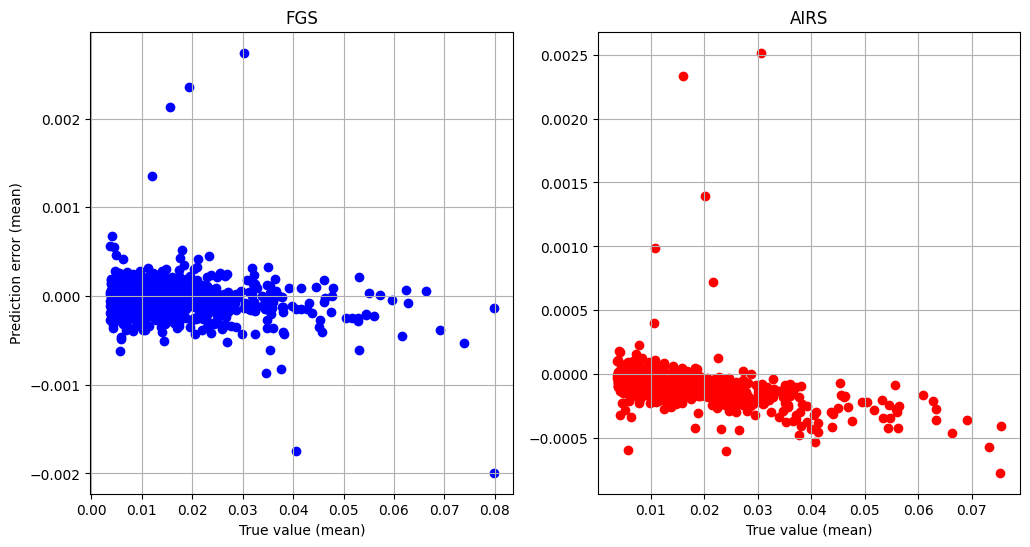

FGS
2270815333, ratio:7.740, x:7.731e-05, y:-5.984e-04, RMS:1.122e-03
94572221, ratio:7.585, x:7.776e-05, y:-5.898e-04, RMS:5.900e-04
2554492145, ratio:6.385, x:1.542e-04, y:9.846e-04, RMS:9.974e-04
4289556715, ratio:5.005, x:1.539e-04, y:-7.704e-04, RMS:8.050e-04
1349926825, ratio:4.754, x:1.199e-04, y:-5.698e-04, RMS:1.166e-03
AIRS
2270815333, ratio:15.622, x:3.830e-05, y:-5.984e-04, RMS:1.122e-03
94572221, ratio:13.329, x:4.425e-05, y:-5.898e-04, RMS:5.900e-04
3649218579, ratio:11.802, x:2.131e-04, y:2.515e-03, RMS:2.518e-03
2554492145, ratio:10.829, x:9.092e-05, y:9.846e-04, RMS:9.974e-04
576917580, ratio:7.985, x:1.746e-04, y:1.394e-03, RMS:1.401e-03


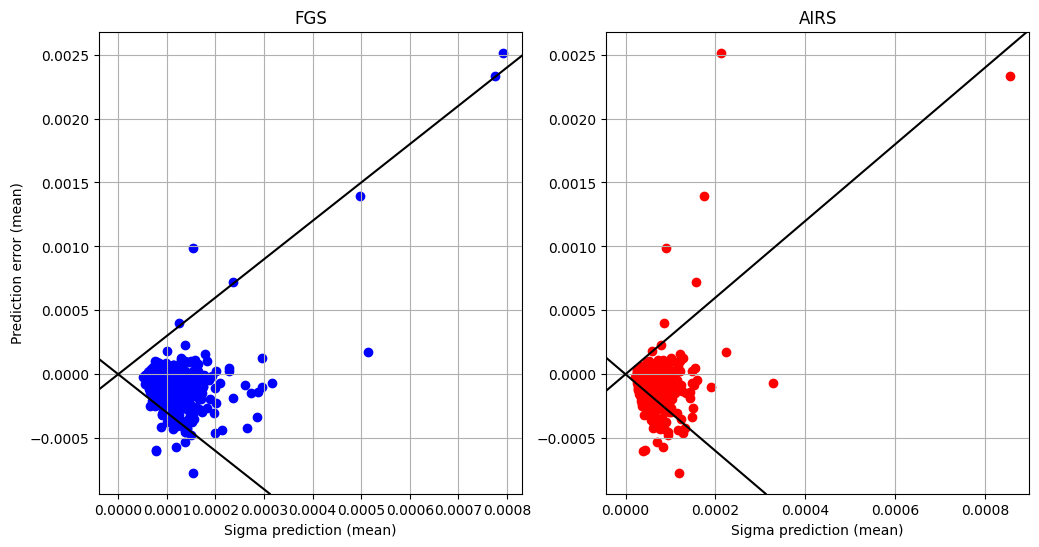

AIRS variation
2270815333, ratio:7.854, x:1.211e-04, y:9.511e-04, RMS:1.122e-03
1349926825, ratio:7.792, x:1.300e-04, y:1.013e-03, RMS:1.166e-03
1345089302, ratio:4.535, x:1.478e-05, y:6.705e-05, RMS:1.277e-04
926530491, ratio:4.398, x:1.593e-05, y:7.009e-05, RMS:7.408e-05
1843015807, ratio:4.041, x:1.602e-05, y:6.475e-05, RMS:2.335e-03


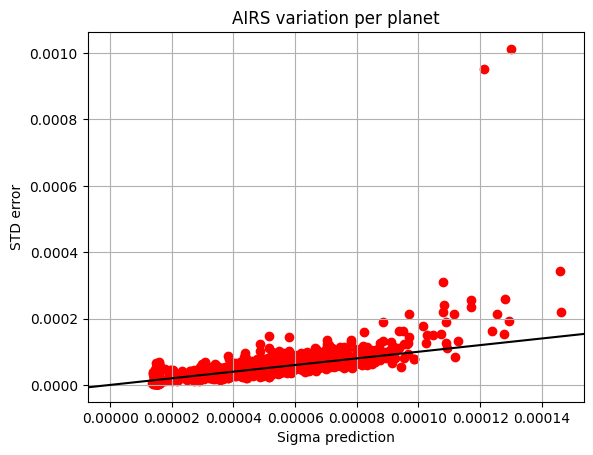

In [8]:
def basics():
    plt.grid(True)
    plt.box(True)
def plot_two_sensors(func, xl, yl, mod):
    _,ax = plt.subplots(1,2,figsize=(12,6))
    plt.sca(ax[0]);basics()
    plt.title('FGS')
    plt.xlabel(xl)
    plt.ylabel(yl)
    func(slice(0,1), 'blue', 'FGS')
    mod()
    
    plt.sca(ax[1]);basics()
    plt.title('AIRS')
    plt.xlabel(xl)
    func(slice(1,283), 'red', 'AIRS')
    mod()
    
    plt.pause(0.001)

def report_extreme_ratios(x,y,name):
    print(name)
    inds = np.argsort(np.abs(y/x))[::-1]
    for ii in inds[:5]:
        print(f'{inferred_data[ii].planet_id}, ratio:{np.abs(y[ii]/x[ii]):.3f}, x:{x[ii]:.3e}, y:{y[ii]:.3e}, RMS:{kgs.rms(error_matrix[ii,:]):.3e}')
    
    
for k,v in todo.items():
    (inferred_data,model) = kgs.dill_load(fname(k))
    #model.bias_a[0]+=0.006
    #model.bias_a[1]-=0.0002
    #inferred_data = model.infer(train_data)
    print(k)
    print(model.bias_a)
    print(model.bias_b)
    print(model.sigma_fudge)
    kgs.score_metric(inferred_data, train_data)
    model.sigma_fudge = [1,1]
    model.bias_a = [1,1]
    model.bias_b = [0,0]
    print('!!!')
    inferred_data = model.infer(train_data)
    kgs.score_metric(inferred_data, train_data)    
    error_matrix = np.array([d.spectrum - t.spectrum for d,t in zip(inferred_data,train_data)])
    true_matrix = np.array([t.spectrum for d,t in zip(inferred_data,train_data)])
    
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(true_matrix[:,slic],1)
        y = np.mean(error_matrix[:,slic],1)
        plt.scatter(x,y,color = col)
        
    plot_two_sensors(plot_prediction_vs_true, 'True value (mean)', 'Prediction error (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data]
        y = np.mean(error_matrix[:,1:],1)
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)
    def mod():
        plt.axline((0,0), slope=3, color='black')
        plt.axline((0,0), slope=-3, color = 'black')        
    plot_two_sensors(plot_mean_error_vs_sigma, 'Sigma prediction (mean)', 'Prediction error (mean)', mod)
    
    plt.figure(); basics()
    plt.title('AIRS variation per planet')
    plt.xlabel('Sigma prediction')
    plt.ylabel('STD error')
    n=282
    x=np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
    y=np.sqrt(np.var(error_matrix[:,1:],1))
    plt.scatter(x, y, color='red')
    plt.axline((0,0), slope=1, color='black')
    report_extreme_ratios(x,y,'AIRS variation')    
    plt.pause(0.001)

In [6]:
# import subprocess

# # Hibernate Windows
# subprocess.run(
#     ["/mnt/c/Windows/System32/shutdown.exe", "/h"],  # add "/f" to force-close apps
#     check=True
# )